In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import os
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from more_itertools import chunked


In [5]:
model = keras.models.load_model("saved_model_10_epochs.h5")
meta_data = pd.read_csv("heysem_data/eth_gender_anno_all.xlsx - eth_gender_trait_annotations_de.csv")
# use same encoding 
meta_data['Gender'] = meta_data["Gender"].replace(2, 0)

In [6]:
# clear difference in occurences in data
meta_data["Ethnicity"].value_counts()

Ethnicity
2    8598
3    1071
1     331
Name: count, dtype: int64

In [7]:
def load_and_preprocess_image(image_path):
    # NOTE: ensure this matches the original model!!!
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    # img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

In [8]:
# ends with .JPG is just a safety measure, unsure if needed
img_paths = ["heysem_data/dev/" + file for file in os.listdir("heysem_data/dev/") if file.endswith('.JPG')]

# first_and_last = img_paths[:500] + img_paths[-500:]
image_data = [load_and_preprocess_image(path) for path in img_paths]

In [10]:
batches = chunked(image_data, 64)

In [ ]:
# # this takes qiuite a long time (~8 sec for 200 paths on teun's laptop)
# dataset = tf.data.Dataset.from_tensor_slices(image_data).batch(64)

In [12]:
# this takes a long time on my laptop, 1-2min on 200 samples
predictions = []
for batch in batches:
    dataset = tf.data.Dataset.from_tensor_slices(image_data)
    # argmax with axis=1 to get label immediately
    predictions.append(np.argmax(model.predict(dataset), axis=1))
    break

In [ ]:
results_dict = {}

# hstack to flatten predictions
for pred, path in zip(np.hstack(predictions), img_paths):
    trim_path = path[16:-4]
    row = meta_data.loc[meta_data["VideoName"] == trim_path]
    # print(row)
    # print(tuple(row[["Ethnicity", "Gender"]].values))
    ethnicity, gender = tuple(row[["Ethnicity", "Gender"]].values[0])

    results_dict[trim_path] = (pred, ethnicity, gender) 
    

In [ ]:
df = pd.DataFrame.from_dict(results_dict).T
df.columns = ["gender_prediction", "ethnicity", "gender_true"]
print(df.shape)
df.head()

(1000, 3)


,gender_prediction,ethnicity,gender_true
--Ymqszjv54.001.mp4,1,2,1
--Ymqszjv54.003.mp4,1,2,1
--Ymqszjv54.004.mp4,1,2,1
--Ymqszjv54.005.mp4,1,2,1
-2qsCrkXdWs.001.mp4,1,2,1




Asian
Accuracy: 0.657


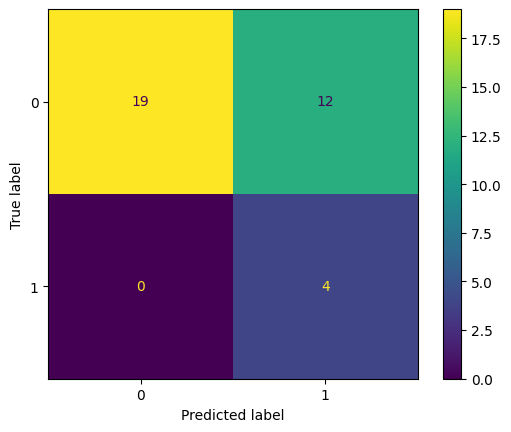



Caucasian
Accuracy: 0.747


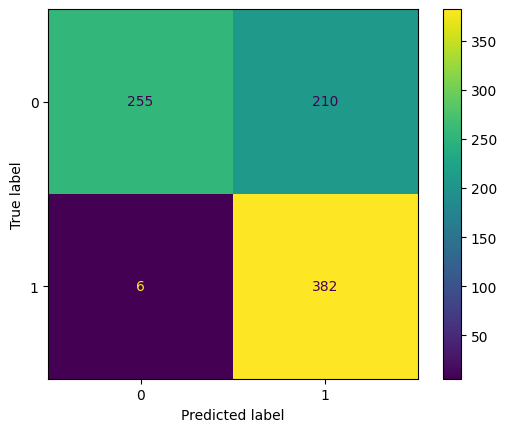



African-American
Accuracy: 0.455


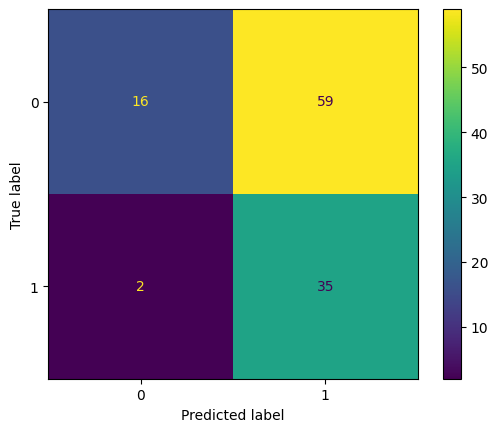

In [ ]:
# index to ethnicity according to orignal dataset
i2e = {1: "Asian", 2:"Caucasian", 3:"African-American"}

for e in i2e.keys():
    e_df = df.loc[df['ethnicity']==e]
    
    print(f"\n\n{i2e[e]}")
    acc = round(sum(e_df['gender_prediction'] == e_df['gender_true'])/len(e_df), 3)

    print(f"Accuracy: {acc}")
    cm = confusion_matrix(e_df["gender_true"], e_df["gender_prediction"])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()